In [1]:
import pandas as pd
import numpy as np
import _pickle

In [2]:
with open('../regular_data_ready_for_model', 'rb') as f:
    df = _pickle.load(f)
df.head()

,rent,latitude,longitude,oda_sayisi,salon_sayisi,brut_m2,net_m2,bina_yasi,kat_sayisi,esyali,...,binned_bulundugu_kat_cat_1,binned_bulundugu_kat_cat_10,binned_bulundugu_kat_cat_11,binned_bulundugu_kat_cat_2,binned_bulundugu_kat_cat_3,binned_bulundugu_kat_cat_4,binned_bulundugu_kat_cat_6,binned_bulundugu_kat_cat_7,binned_bulundugu_kat_cat_8,binned_bulundugu_kat_cat_9
8262,30000,41.043127,28.969064,2,1,100,75,1,8.0,1,...,0,0,1,0,0,0,0,0,0,0
8260,8000,40.979325,28.729905,3,1,145,130,30,5.0,0,...,0,0,1,0,0,0,0,0,0,0
7889,10000,41.057928,28.974291,3,1,110,100,15,5.0,0,...,0,0,1,0,0,0,0,0,0,0
7919,65000,41.152676,28.924586,3,1,165,121,0,3.0,0,...,0,0,0,0,0,1,0,0,0,0
7923,55000,41.207677,29.020296,6,2,450,430,16,4.0,0,...,0,1,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10255 entries, 8262 to 10947
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   rent                         10255 non-null  int32  
 1   latitude                     9191 non-null   float64
 2   longitude                    9191 non-null   float64
 3   oda_sayisi                   10255 non-null  object 
 4   salon_sayisi                 10255 non-null  object 
 5   brut_m2                      10255 non-null  int64  
 6   net_m2                       10255 non-null  int64  
 7   bina_yasi                    10255 non-null  int32  
 8   kat_sayisi                   10243 non-null  float64
 9   esyali                       10255 non-null  int32  
 10  banyo_sayisi                 10247 non-null  float64
 11  site_icerisinde_binary       10255 non-null  bool   
 12  dogu                         10255 non-null  bool   
 13  bati         

In [4]:
categorical_cols = [col for col in df.columns if df[col].dtype == 'uint8']
df[categorical_cols] = df[categorical_cols].astype('int')

df['oda_sayisi'] = pd.to_numeric(df['oda_sayisi'], errors='coerce')
df['salon_sayisi'] = pd.to_numeric(df['salon_sayisi'], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10255 entries, 8262 to 10947
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   rent                         10255 non-null  int32  
 1   latitude                     9191 non-null   float64
 2   longitude                    9191 non-null   float64
 3   oda_sayisi                   10255 non-null  int64  
 4   salon_sayisi                 10255 non-null  int64  
 5   brut_m2                      10255 non-null  int64  
 6   net_m2                       10255 non-null  int64  
 7   bina_yasi                    10255 non-null  int32  
 8   kat_sayisi                   10243 non-null  float64
 9   esyali                       10255 non-null  int32  
 10  banyo_sayisi                 10247 non-null  float64
 11  site_icerisinde_binary       10255 non-null  bool   
 12  dogu                         10255 non-null  bool   
 13  bati         

# training and validation

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X, y = df.drop('rent', axis=1), df['rent']

In [7]:
y.describe()

count    10255.000000
mean     20680.742467
std      14446.531105
min          1.000000
25%      10000.000000
50%      16000.000000
75%      26000.000000
max      70000.000000
Name: rent, dtype: float64

<AxesSubplot:>

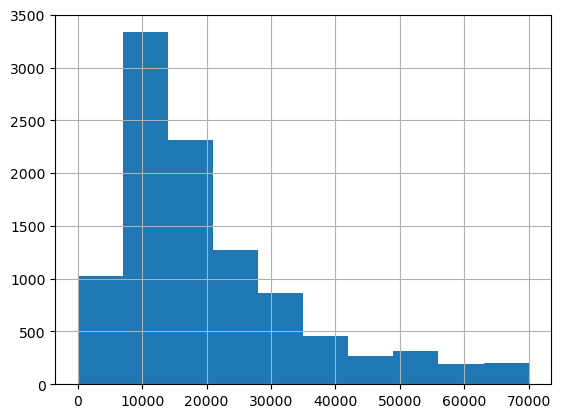

In [8]:
y.hist()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9229, 54), (1026, 54), (9229,), (1026,))

In [11]:
# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=11)

In [12]:
# X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

# hyperparameter optimization

In [13]:
import xgboost as xgb
import optuna

In [16]:
def objective(trial: optuna.Trial, X_train, y_train, tree_count) -> float:
    
    params = {"objective":'reg:squarederror',
              'max_depth':trial.suggest_int('max_depth', 2, 16),
              'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
              'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
              'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
              'gamma':trial.suggest_int('gamma', 0, 5),
              'learning_rate':trial.suggest_float('learning_rate',0.005,0.5, log=True),
              'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01)}
    
    boosting_rounds = 1000
    dtrain = xgb.DMatrix(data=X_train,label=y_train)
    
    xgb_cv = xgb.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=boosting_rounds, 
                    early_stopping_rounds=20, metrics="mae", as_pandas=True, seed=123)
    
    num_trees = xgb_cv['test-mae-mean'].argmin() + 1
    tree_count[len(tree_count)] = num_trees
    
    return xgb_cv['test-mae-mean'].min()

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tree_count = {}
study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial : objective(trial, X_train, y_train, tree_count=tree_count), n_trials=10)

[I 2023-02-19 13:51:09,069] A new study created in memory with name: no-name-c855ed23-45d3-4679-8d27-313af72b4f5f
[I 2023-02-19 13:51:49,015] Trial 0 finished with value: 4716.921671871053 and parameters: {'max_depth': 5, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 4, 'learning_rate': 0.017315224386737174, 'colsample_bytree': 0.58}. Best is trial 0 with value: 4716.921671871053.
[I 2023-02-19 13:52:16,547] Trial 1 finished with value: 5784.084452082416 and parameters: {'max_depth': 2, 'reg_alpha': 0, 'reg_lambda': 4, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.013386652953556101, 'colsample_bytree': 0.72}. Best is trial 0 with value: 4716.921671871053.
[I 2023-02-19 13:53:28,751] Trial 2 finished with value: 4406.203833997466 and parameters: {'max_depth': 12, 'reg_alpha': 0, 'reg_lambda': 4, 'min_child_weight': 4, 'gamma': 3, 'learning_rate': 0.03383244382182443, 'colsample_bytree': 0.92}. Best is trial 2 with value: 4406.203833997466.
[I 2023-02-19 13:53

In [25]:
trials_df = study.trials_dataframe().sort_values('value', ascending=True)
trials_df.iloc[:5]

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_reg_alpha,params_reg_lambda,state
2,2,4406.203834,2023-02-19 13:52:16.548768,2023-02-19 13:53:28.750275,0 days 00:01:12.201507,0.92,3,0.033832,12,4,0,4,COMPLETE
8,8,4441.337793,2023-02-19 13:58:36.897917,2023-02-19 14:00:35.968736,0 days 00:01:59.070819,0.93,4,0.014056,14,4,5,2,COMPLETE
4,4,4567.310127,2023-02-19 13:53:41.920127,2023-02-19 13:57:26.399292,0 days 00:03:44.479165,0.98,0,0.006560,14,1,2,1,COMPLETE
0,0,4716.921672,2023-02-19 13:51:09.070726,2023-02-19 13:51:49.014643,0 days 00:00:39.943917,0.58,4,0.017315,5,1,1,3,COMPLETE
3,3,5002.665762,2023-02-19 13:53:28.752279,2023-02-19 13:53:41.917127,0 days 00:00:13.164848,0.24,0,0.346807,4,2,4,5,COMPLETE


In [26]:
def objective(trial: optuna.Trial, X_train, y_train, tree_count) -> float:
    
    params = {"objective":'reg:squarederror',
              'max_depth':trial.suggest_int('max_depth', 10, 16),
              'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
              'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
              'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
              'gamma':trial.suggest_int('gamma', 0, 5),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.04, log=True),
              'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree', 0.85, 1, 0.01)}
    
    boosting_rounds = 1000
    dtrain = xgb.DMatrix(data=X_train,label=y_train)
    
    xgb_cv = xgb.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=boosting_rounds, 
                    early_stopping_rounds=20, metrics="mae", as_pandas=True, seed=123)
    
    num_trees = xgb_cv['test-mae-mean'].argmin() + 1
    tree_count[len(tree_count)] = num_trees
    
    return xgb_cv['test-mae-mean'].min()

In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tree_count = {}
study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial : objective(trial, X_train, y_train, tree_count=tree_count), n_trials=20)

[I 2023-02-19 14:08:34,452] A new study created in memory with name: no-name-d12ffd1f-abf8-4125-9cd3-6df17e815f2e
[I 2023-02-19 14:10:33,515] Trial 0 finished with value: 4500.779280226325 and parameters: {'max_depth': 15, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 4, 'gamma': 2, 'learning_rate': 0.019800557041810128, 'colsample_bytree': 0.86}. Best is trial 0 with value: 4500.779280226325.
[I 2023-02-19 14:11:27,974] Trial 1 finished with value: 4487.515685403743 and parameters: {'max_depth': 13, 'reg_alpha': 4, 'reg_lambda': 0, 'min_child_weight': 4, 'gamma': 3, 'learning_rate': 0.037800691433481325, 'colsample_bytree': 0.86}. Best is trial 1 with value: 4487.515685403743.
[I 2023-02-19 14:14:06,149] Trial 2 finished with value: 4481.824455047864 and parameters: {'max_depth': 15, 'reg_alpha': 0, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 4, 'learning_rate': 0.01525928564155537, 'colsample_bytree': 0.89}. Best is trial 2 with value: 4481.824455047864.
[I 2023-02-19 14:

In [29]:
study.best_params

{'max_depth': 12,
 'reg_alpha': 4,
 'reg_lambda': 4,
 'min_child_weight': 5,
 'gamma': 2,
 'learning_rate': 0.011938538816069405,
 'colsample_bytree': 0.88}

In [31]:
print(tree_count)

{0: 906, 1: 464, 2: 858, 3: 1000, 4: 525, 5: 735, 6: 245, 7: 505, 8: 834, 9: 1000, 10: 1000, 11: 1000, 12: 1000, 13: 999, 14: 1000, 15: 1000, 16: 1000, 17: 1000, 18: 999, 19: 962}


In [32]:
tree_count[16]

1000

In [33]:
params = {"objective":'reg:squarederror',
          'max_depth': 12,
         'reg_alpha': 4,
         'reg_lambda': 4,
         'min_child_weight': 5,
         'gamma': 2,
         'learning_rate': 0.011938538816069405,
         'colsample_bytree': 0.88}

boosting_rounds = 2000  # increase the num of trees
dtrain = xgb.DMatrix(data=X_train,label=y_train)

xgb_cv = xgb.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=boosting_rounds, 
                early_stopping_rounds=20, metrics="mae", as_pandas=True, seed=123)

In [34]:
num_trees = xgb_cv['test-mae-mean'].argmin() + 1
print(num_trees)
xgb_cv['test-mae-mean'].min()

1897


4355.729798200143

In [49]:
params = {'objective':'reg:squarederror',
         'max_depth': 12,
         'reg_alpha': 4,
         'reg_lambda': 4,
         'min_child_weight': 5,
         'gamma': 2,
         'learning_rate': 0.011938538816069405,
         'colsample_bytree': 0.88,
         'n_estimators': num_trees,
         'missing':np.nan,
         'seed':1}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.88, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.011938538816069405,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=1897, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [61]:
# with open('xgb_trained', 'wb') as f:
#     _pickle.dump(model, f)

# residual analysis

In [50]:
from sklearn.metrics import mean_absolute_error

In [51]:
preds = model.predict(X_test)
mean_absolute_error(y_test, preds)

4175.0078186867995

In [52]:
df_model = pd.DataFrame({'pred': preds, 'true': y_test, 'residual': y_test - preds})
df_model

,pred,true,residual
6705,40651.281250,60000,19348.718750
1484,16433.822266,17000,566.177734
6478,7175.735352,10000,2824.264648
8181,25812.732422,27500,1687.267578
5854,54145.304688,54950,804.695312
...,...,...,...
4279,14306.596680,19000,4693.403320
7213,12726.775391,15000,2273.224609
756,19035.000000,17500,-1535.000000
1866,31843.058594,27500,-4343.058594


In [55]:
df_model['residual'].describe()

count     1026.000000
mean       -37.524395
std       6683.018669
min     -37893.273438
25%      -2772.121582
50%       -455.149414
75%       2003.704590
max      48849.937500
Name: residual, dtype: float64

In [57]:
import matplotlib.pyplot as plt

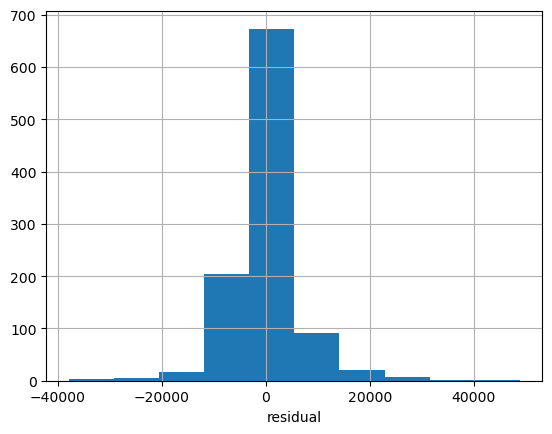

In [59]:
df_model['residual'].hist()
plt.xlabel('residual')
plt.show()

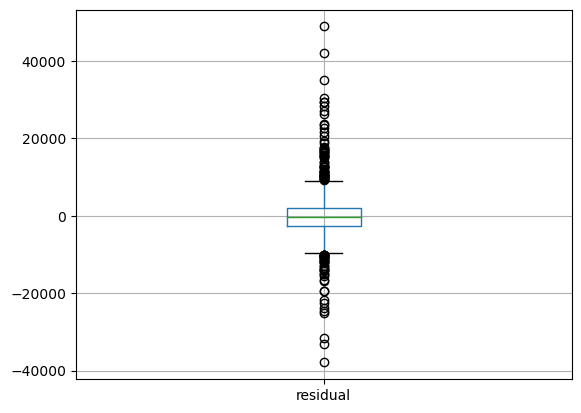

In [63]:
df_model.boxplot('residual')
plt.show()

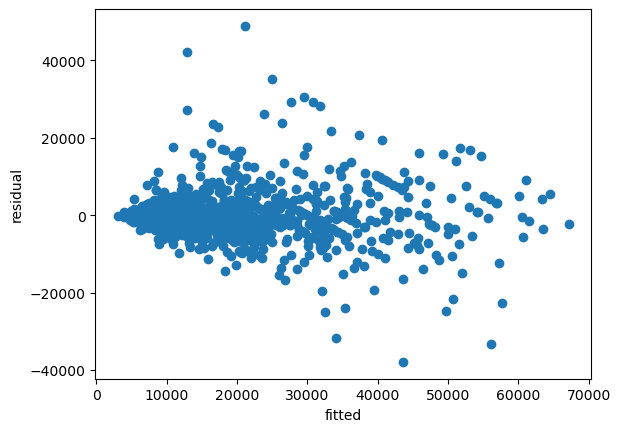

In [60]:
plt.scatter(x=df_model['pred'], y=df_model['residual'])
plt.xlabel('fitted')
plt.ylabel('residual')
plt.show()

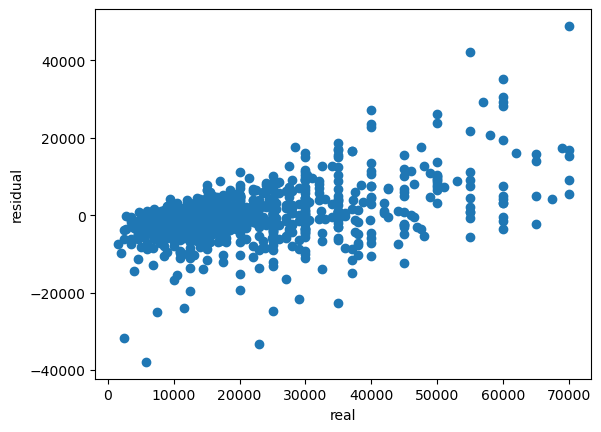

In [66]:
plt.scatter(x=df_model['true'], y=df_model['residual'])
plt.xlabel('real')
plt.ylabel('residual')
plt.show()

The model did a relatively good job predicting the low-average rents where it tends to fail when it comes to higher ones. The reason for this might be that the learning algorithm is tree-based, hence poor in interpolating, and that the high outlier values were dropped in the preprocessing phase. As the high-value outliers in the target vector were dropped and there are now even fewer high-value observations So, the interpolation capability of xgboost was harmed. 

# model interpretation

In [67]:
import shap

In [87]:
explainer = shap.TreeExplainer(model)

In [88]:
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


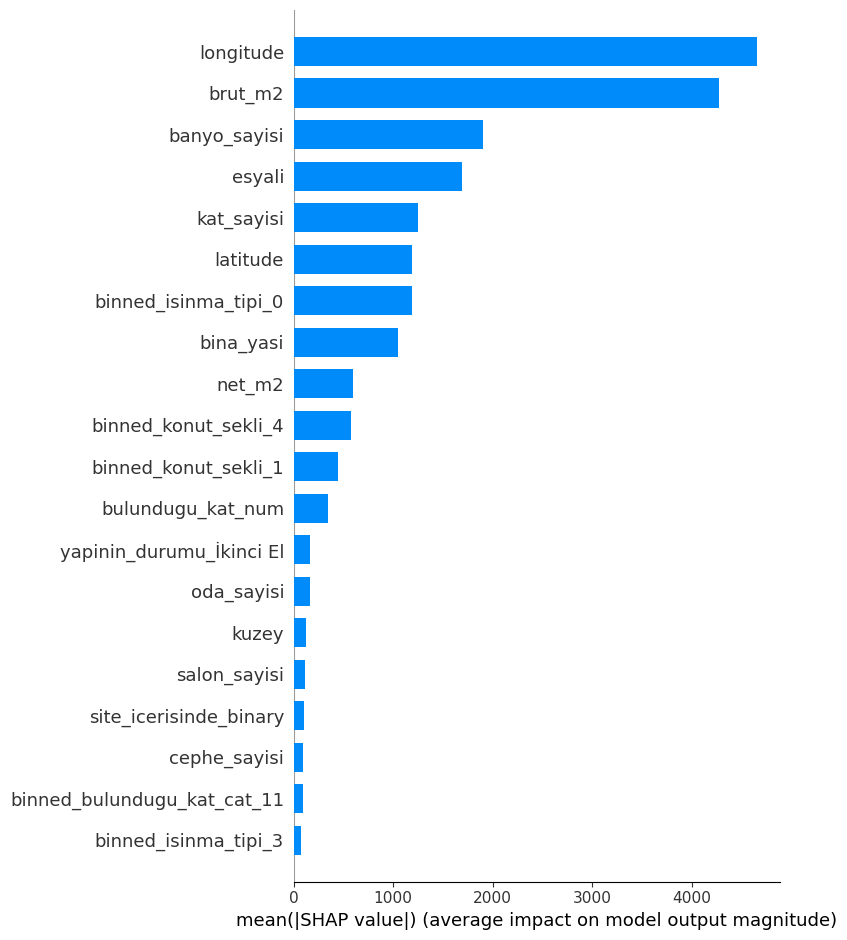

In [89]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

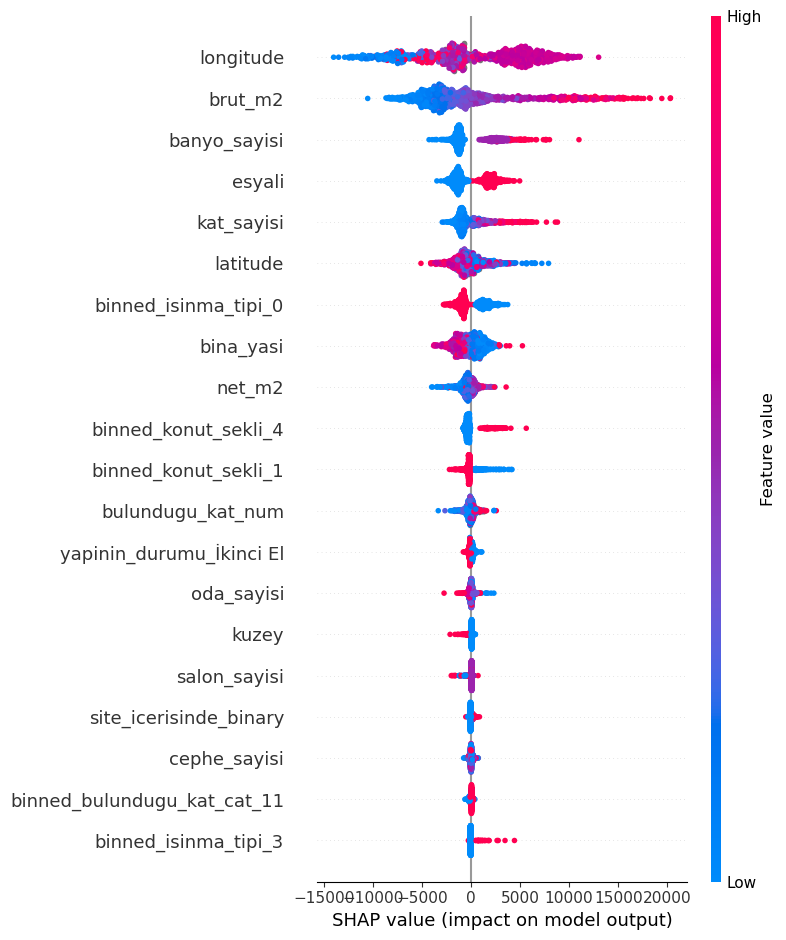

In [90]:
shap.summary_plot(shap_values, X_test)

i. Being on the western side of the city has generally a decreasing impact on the rent. Being on the northern side has a general decreasing effect as well.

ii. brut_m^2 (gross m^2) has a clear positive effect on the rent.

iii. This is also true for banyo_sayisi (number of bathrooms), esyali (is_furnished), and kat_sayisi (number of floors). The impact of banyo_sayisi is somehow surprising. This is probably due to its correlation between the number of rooms (oda_sayisi) and the number of living rooms (salon_sayisi). Though they have strong correlations between each other, there were not dropped during preprocessing.

In [91]:
explanations = explainer(X_test)

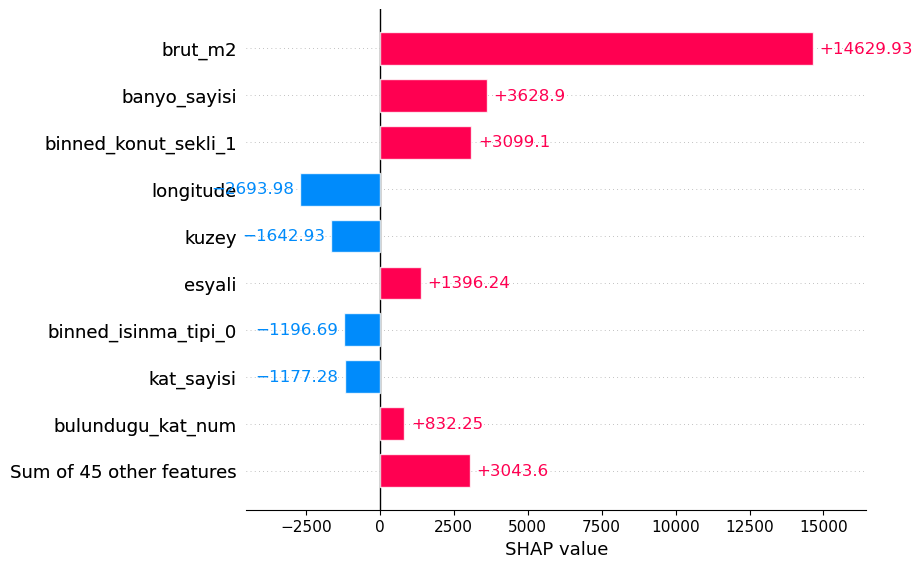

In [92]:
shap.plots.bar(explanations[0])

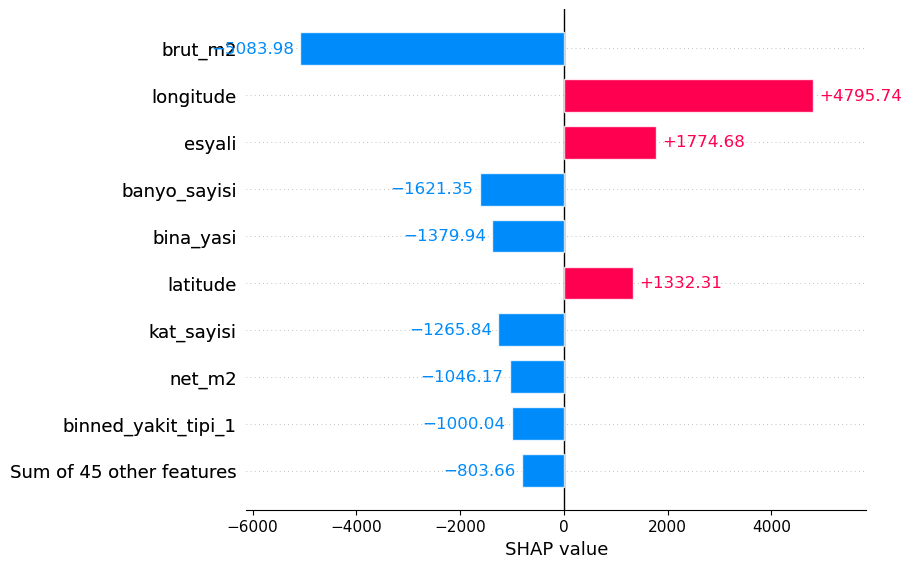

In [93]:
shap.plots.bar(explanations[1])

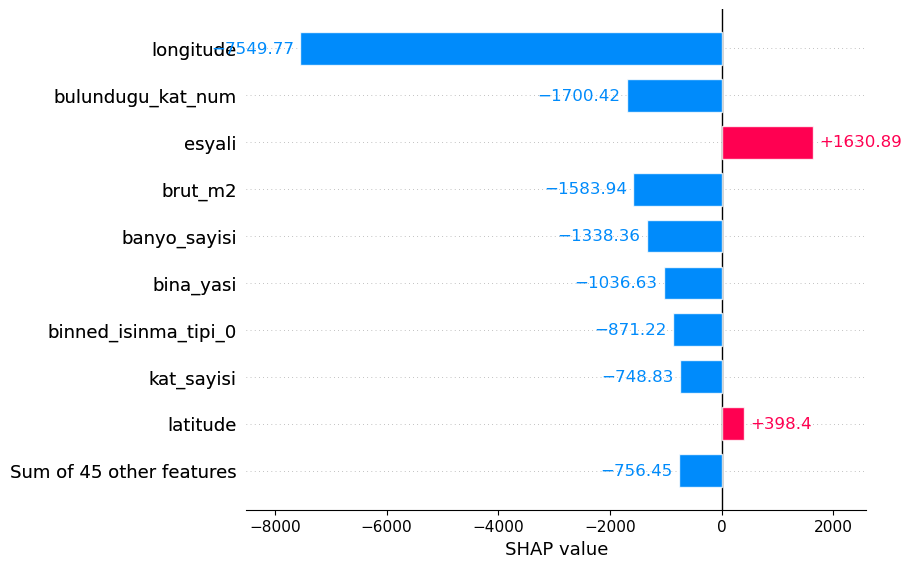

In [94]:
shap.plots.bar(explanations[2])